In [1]:
import gzip, pickle
import os
import numpy as np
import pandas as pd
import random
import shutil
import numpy as np
import os, zipfile
import xml.etree.ElementTree as ET 
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
from scipy import linalg
import matplotlib.pyplot as plt
import gc
import urllib
import warnings
from PIL import Image
from tqdm import tqdm_notebook as tqdm


In [2]:
with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as z:
    z.extractall(".")

In [3]:
with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as z:
    z.extractall(".")


In [4]:
dogs = os.listdir('./all-dogs/')


In [5]:
print("Total Images =", len(dogs))
print("Total breeds=", len(os.listdir('./Annotation')))

Total Images = 20579
Total breeds= 120


# 1. ****Preprocessing on Dog Images****

Here, We preprocessing images by cropping only dogs from images using the bounding box from Annotation.


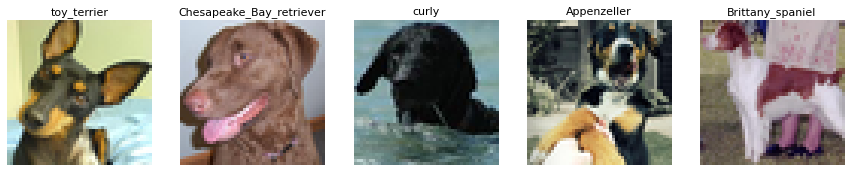

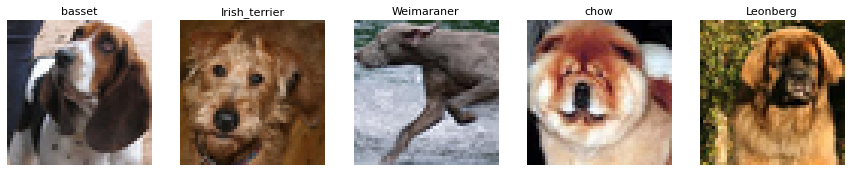

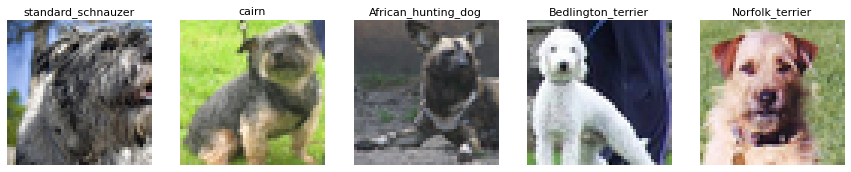

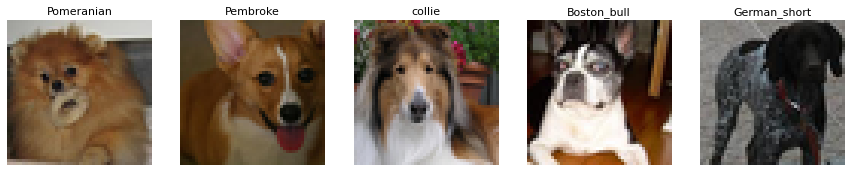

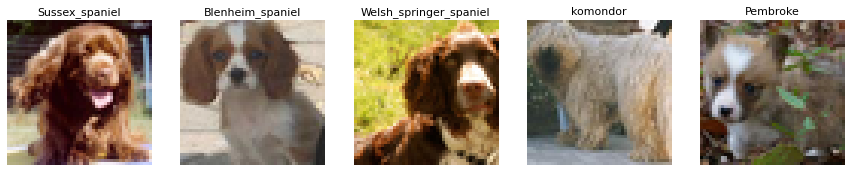

In [6]:
All_dogs = os.listdir('./all-dogs/')
All_breeds = os.listdir('./Annotation/') 
counter = 0; names = []
Training_dogs = np.zeros((25000,48,48,3))

for breed in All_breeds:
    for dog in os.listdir('./Annotation/'+breed):
        try: img = Image.open('./all-dogs/'+dog+'.jpg') 
        except: continue           
        tree = ET.parse('./Annotation/'+breed+'/'+dog)
        root = tree.getroot()
        objects = root.findall('object')
        for o in objects:
            bndbox = o.find('bndbox') 
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            w = np.min((xmax - xmin, ymax - ymin))
            img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
            img2 = img2.resize((48,48), Image.ANTIALIAS)
            Training_dogs[counter,:,:,:] = np.asarray(img2)
            names.append(breed)
            counter += 1
idx = np.arange(counter)
np.random.shuffle(idx)
Training_dogs = Training_dogs[idx,:,:,:]
names = np.array(names)[idx]
    
x = np.random.randint(0,counter,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( Training_dogs[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        plt.title(names[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()


In [7]:
print(Training_dogs.shape)
print(len(idx))

(22125, 48, 48, 3)
22125


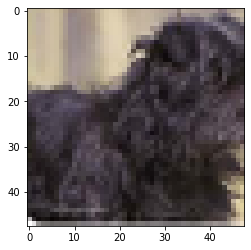

In [8]:
img=Image.fromarray(Training_dogs[12123,:,:,:].astype('uint8') )
plt.imshow(img)

In [9]:
class MaskConv2d(nn.Conv2d):
    
    def __init__(self, mask_type, *args, **kwargs):
        
        assert mask_type == 'A' or mask_type == 'B'
        super().__init__(*args, **kwargs)
        self.register_buffer('mask', torch.zeros_like(self.weight))
        self.create_mask(mask_type)
        
    def create_mask(self, mask_type):
        
        k = self.kernel_size[0]
        self.mask[:, :, :k // 2] = 1
        self.mask[:, :, k // 2, :k // 2] = 1
        assert self.in_channels % 3 == 0 and self.out_channels % 3 == 0
        one_third_in, one_third_out = self.in_channels // 3, self.out_channels // 3
        if mask_type == 'B':
            self.mask[:one_third_out, :one_third_in, k // 2, k // 2] = 1
            self.mask[one_third_out:2*one_third_out, :2*one_third_in, k // 2, k // 2] = 1
            self.mask[2*one_third_out:, :, k // 2, k // 2] = 1
        else:
            self.mask[one_third_out:2*one_third_out, :one_third_in, k // 2, k // 2] = 1
            self.mask[2*one_third_out:, :2*one_third_in, k // 2, k // 2] = 1
        
    def forward(self, input):
        
        batch_size = input.shape[0]
        out = F.conv2d(input, self.weight * self.mask, self.bias, self.stride,
                   self.padding, self.dilation, self.groups)
        return out
    

In [10]:
class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels):
        super().__init__()
        self.resblock = nn.ModuleList([
            nn.ReLU(),
            MaskConv2d('B', in_channels, in_channels // 2, 1),#1*1 conv
            nn.ReLU(),
            MaskConv2d('B', in_channels // 2, in_channels // 2, 7, padding=3), #7*7 conv
            nn.ReLU(),
            MaskConv2d('B', in_channels // 2, in_channels, 1) #1*1 conv
        ])
        
    def forward(self, x):
        out = x
        for layer in self.resblock:
            out = layer(out)
        return out + x

In [11]:
class LayerNorm(nn.LayerNorm):
    
    def __init__(self, *args):
        
        super().__init__(*args)
    
    def forward(self, x):
        
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = x.contiguous().view(*(x_shape[:-1] + (3, -1)))
        x = super().forward(x)
        x = x.view(*x_shape)
        return x.permute(0, 3, 1, 2).contiguous()

In [12]:
class PixelCNN(nn.Module):
    
    def __init__(self, input_shape, n_colors, n_filters=64, kernel_size=7, n_layers=5):
        
        super().__init__()
        n_channels = input_shape[0]
        self.input_shape = input_shape
        self.n_colors = n_colors
        self.n_channels = n_channels
        self.kernel_size = kernel_size
        Residual_block = lambda: ResidualBlock(n_filters)
        model = nn.ModuleList([MaskConv2d('A', n_channels, n_filters, 
                                      kernel_size=kernel_size,
                                      padding=kernel_size // 2)])
        for _ in range(n_layers):
            
            model.append(LayerNorm(n_filters // 3))
            model.extend([nn.ReLU(), Residual_block()])
        model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_filters, 1)])
        model.extend([nn.ReLU(), MaskConv2d('B', n_filters, n_colors * n_channels, 1)])
        
        self.net = model
        
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        out = (x.float() / (self.n_colors - 1) - 0.5) / 0.5
        for layer in self.net:
            out = layer(out)
        return out.view(batch_size, self.n_channels, self.n_colors,
                       *self.input_shape[1:]).permute(0, 2, 1, 3, 4)
    
    def loss(self, x):
        return F.cross_entropy(self(x), x.long())
    
    def sample(self, n):
        samples = torch.zeros(n, *self.input_shape).cuda()
        with torch.no_grad():
            for r in range(self.input_shape[1]):
                for c in range(self.input_shape[2]):
                    for k in range(self.n_channels):
                        logits = self(samples)[:, :, k, r, c]
                        probs = F.softmax(logits, dim = 1)
                        samples[:, k, r, c] = torch.multinomial(probs,
                                                               1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()
        


In [13]:
def Train(model, train_loader, optimizer, epoch, grad_clip=None):
    
    model.train()
    pbar = tqdm(total=len(train_loader.dataset))
    train_losses = []
    for x in train_loader:
        x = x.cuda().contiguous()
        loss = model.loss(x)
        optimizer.zero_grad()
        loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()
        train_losses.append(loss.item())
        pbar.set_description(f'Epoch {epoch}, Train Loss {np.mean(train_losses[-50:]):.4f}')
        pbar.update(x.shape[0])
        pbar.close()
    return train_losses

def eval_loss(model, data_loader):
    
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda().contiguous()
            loss = model.loss(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def train_epochs(model, train_loader, test_loader, train_args):
    
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    test_losses = [eval_loss(model, test_loader)]
    for epoch in range(epochs):
        
        model.train()
        train_losses.extend(Train(model, train_loader, optimizer, epoch, grad_clip))
        test_loss = eval_loss(model, test_loader)
        test_losses.append(test_loss)
        print(f'Epoch {epoch}, Test loss {test_loss:.4f}')

    return train_losses, test_losses



In [14]:
torch.cuda.empty_cache()

In [15]:
train_data = np.transpose(Training_dogs[:16000, :, :, :], (0, 3, 1, 2))
test_data = np.transpose(Training_dogs[16000:17920, :, :, :], (0, 3, 1, 2))
model = PixelCNN((3, 48, 48), 256, n_filters=120, n_layers=12).cuda()
train_args = dict(epochs=18, lr=1e-3, grad_clip=1)
train_loader = data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=64)
del Training_dogs
gc.collect()
train_losses, test_losses = train_epochs(model, train_loader, test_loader, 
                                           train_args)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Epoch 0, Test loss 4.0681



Epoch 1, Test loss 3.8314



Epoch 2, Test loss 4.0747



Epoch 3, Test loss 3.5491



Epoch 4, Test loss 3.5678



Epoch 5, Test loss 3.3887



Epoch 6, Test loss 3.5433



Epoch 7, Test loss 3.3709



Epoch 8, Test loss 3.2783



Epoch 9, Test loss 3.4342



Epoch 10, Test loss 3.2571



Epoch 11, Test loss 3.1984



Epoch 12, Test loss 3.3286



Epoch 13, Test loss 3.2646



Epoch 14, Test loss 3.2757



Epoch 15, Test loss 3.2130



Epoch 16, Test loss 3.1992



Epoch 17, Test loss 3.2161


In [16]:
samples = model.sample(10)

In [17]:
print(samples.shape)

(10, 48, 48, 3)


In [18]:
def show_d_images(imgs):
    with torch.no_grad():
        imgs = imgs.reshape((-1,48,48,3))
        for i in range(2):
            plt.figure(figsize=(20,4))
            for j in range(5):
                plt.subplot(1,5,j+1)
                img = Image.fromarray((imgs[i*2+j, :, :, :]).astype('uint8').reshape((48,48,3)))
                plt.imshow(img)
        plt.show()


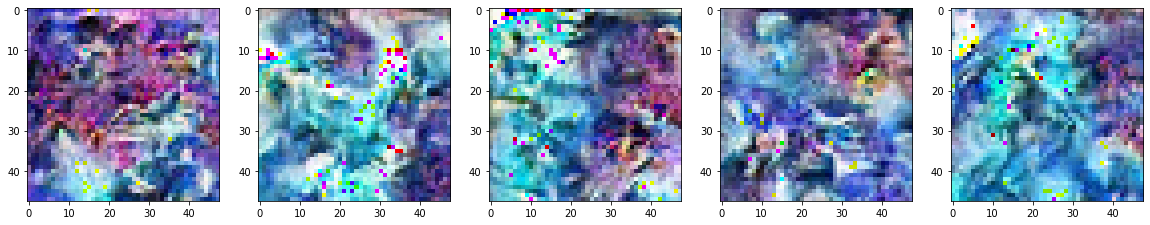

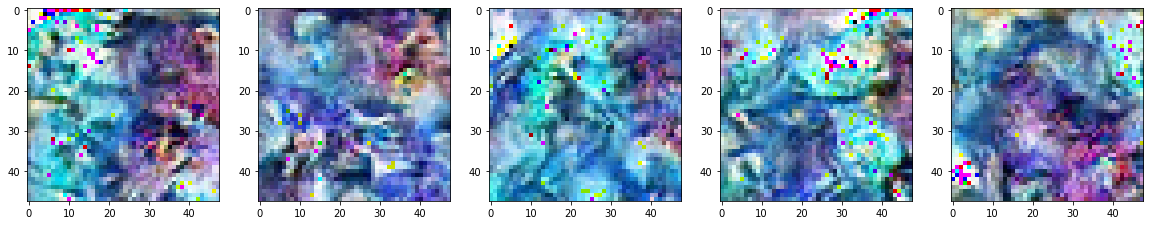

In [19]:
show_d_images(samples)